In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pygmt

In [11]:
datadir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/feature_splits'
p_train = pd.read_csv(os.path.join(datadir, 'p.train.csv'))
s_train = pd.read_csv(os.path.join(datadir, 's.train.csv'))
p_stats = pd.read_csv(os.path.join(datadir, 'p.station.ex.counts.csv'))
s_stats = pd.read_csv(os.path.join(datadir, 's.station.ex.counts.csv'))
stat_df = pd.read_csv('../data/catalogs/stat.info.csv')

In [12]:
# Filter stations to those used kept for training and merge the station location information
p_stats = p_stats[p_stats['station'].isin(p_train['station'].unique())].merge(stat_df, on='station', how='left')
s_stats = s_stats[s_stats['station'].isin(s_train['station'].unique())].merge(stat_df, on='station', how='left')
print(p_stats.shape[0], s_stats.shape[0])
p_stats.head()

34 17


,station,cnt_train,cnt_test,network,receiver_lat,receiver_lon
0,YNR,4009.0,1008,WY,44.71550,-110.67917
1,YHH,4005.0,1002,WY,44.78833,-110.85050
2,YMC,3553.0,898,WY,44.75933,-111.00616
3,YMR,3393.0,845,WY,44.66867,-110.96500
4,YPM,3358.0,843,WY,44.65717,-110.86867


In [16]:
p_train.columns

Index(['arrival_identifier', 'avg_noise_1.00', 'avg_noise_10.00',
       'avg_noise_11.00', 'avg_noise_12.00', 'avg_noise_13.00',
       'avg_noise_14.00', 'avg_noise_15.00', 'avg_noise_16.00',
       'avg_noise_17.00', 'avg_noise_18.00', 'avg_noise_2.00',
       'avg_noise_3.00', 'avg_noise_4.00', 'avg_noise_5.00', 'avg_noise_6.00',
       'avg_noise_7.00', 'avg_noise_8.00', 'avg_noise_9.00', 'avg_signal_1.00',
       'avg_signal_10.00', 'avg_signal_11.00', 'avg_signal_12.00',
       'avg_signal_13.00', 'avg_signal_14.00', 'avg_signal_15.00',
       'avg_signal_16.00', 'avg_signal_17.00', 'avg_signal_18.00',
       'avg_signal_2.00', 'avg_signal_3.00', 'avg_signal_4.00',
       'avg_signal_5.00', 'avg_signal_6.00', 'avg_signal_7.00',
       'avg_signal_8.00', 'avg_signal_9.00', 'channel', 'event_identifier',
       'location_code', 'magnitude', 'magnitude_type', 'network',
       'noise_dominant_amplitude', 'noise_dominant_frequency',
       'noise_maximum_value', 'noise_minimum_value

In [19]:
p_train_ev = p_train[['event_identifier', 'source_latitude', 'source_longitude', 'source_depth_km']].drop_duplicates('event_identifier')
s_train_ev = s_train[['event_identifier', 'source_latitude', 'source_longitude', 'source_depth_km']].drop_duplicates('event_identifier')
print(p_train_ev.shape[0], s_train_ev.shape[0])

5131 4412


In [13]:
# Read in park and caldera boundaries
utahnet_path = '../data/utahnet'
ys_border = pd.read_csv(f"{utahnet_path}/yell.border.g", delimiter=" ", names=["Longitude", "Latitude"], dtype=np.float64)
caldera = pd.read_csv(f"{utahnet_path}/caldera.ys", sep="\s+", names=["Latitude", "Longitude"], dtype=np.float64)

caldera = caldera.drop(caldera[caldera["Longitude"]==0].index)
caldera = caldera[["Longitude", "Latitude"]]
caldera["Longitude"] = caldera["Longitude"]*-1
caldera.head()

,Longitude,Latitude
0,-110.6149,44.7057
1,-110.6154,44.7040
2,-110.6158,44.7023
3,-110.6162,44.7003
4,-110.6158,44.6986


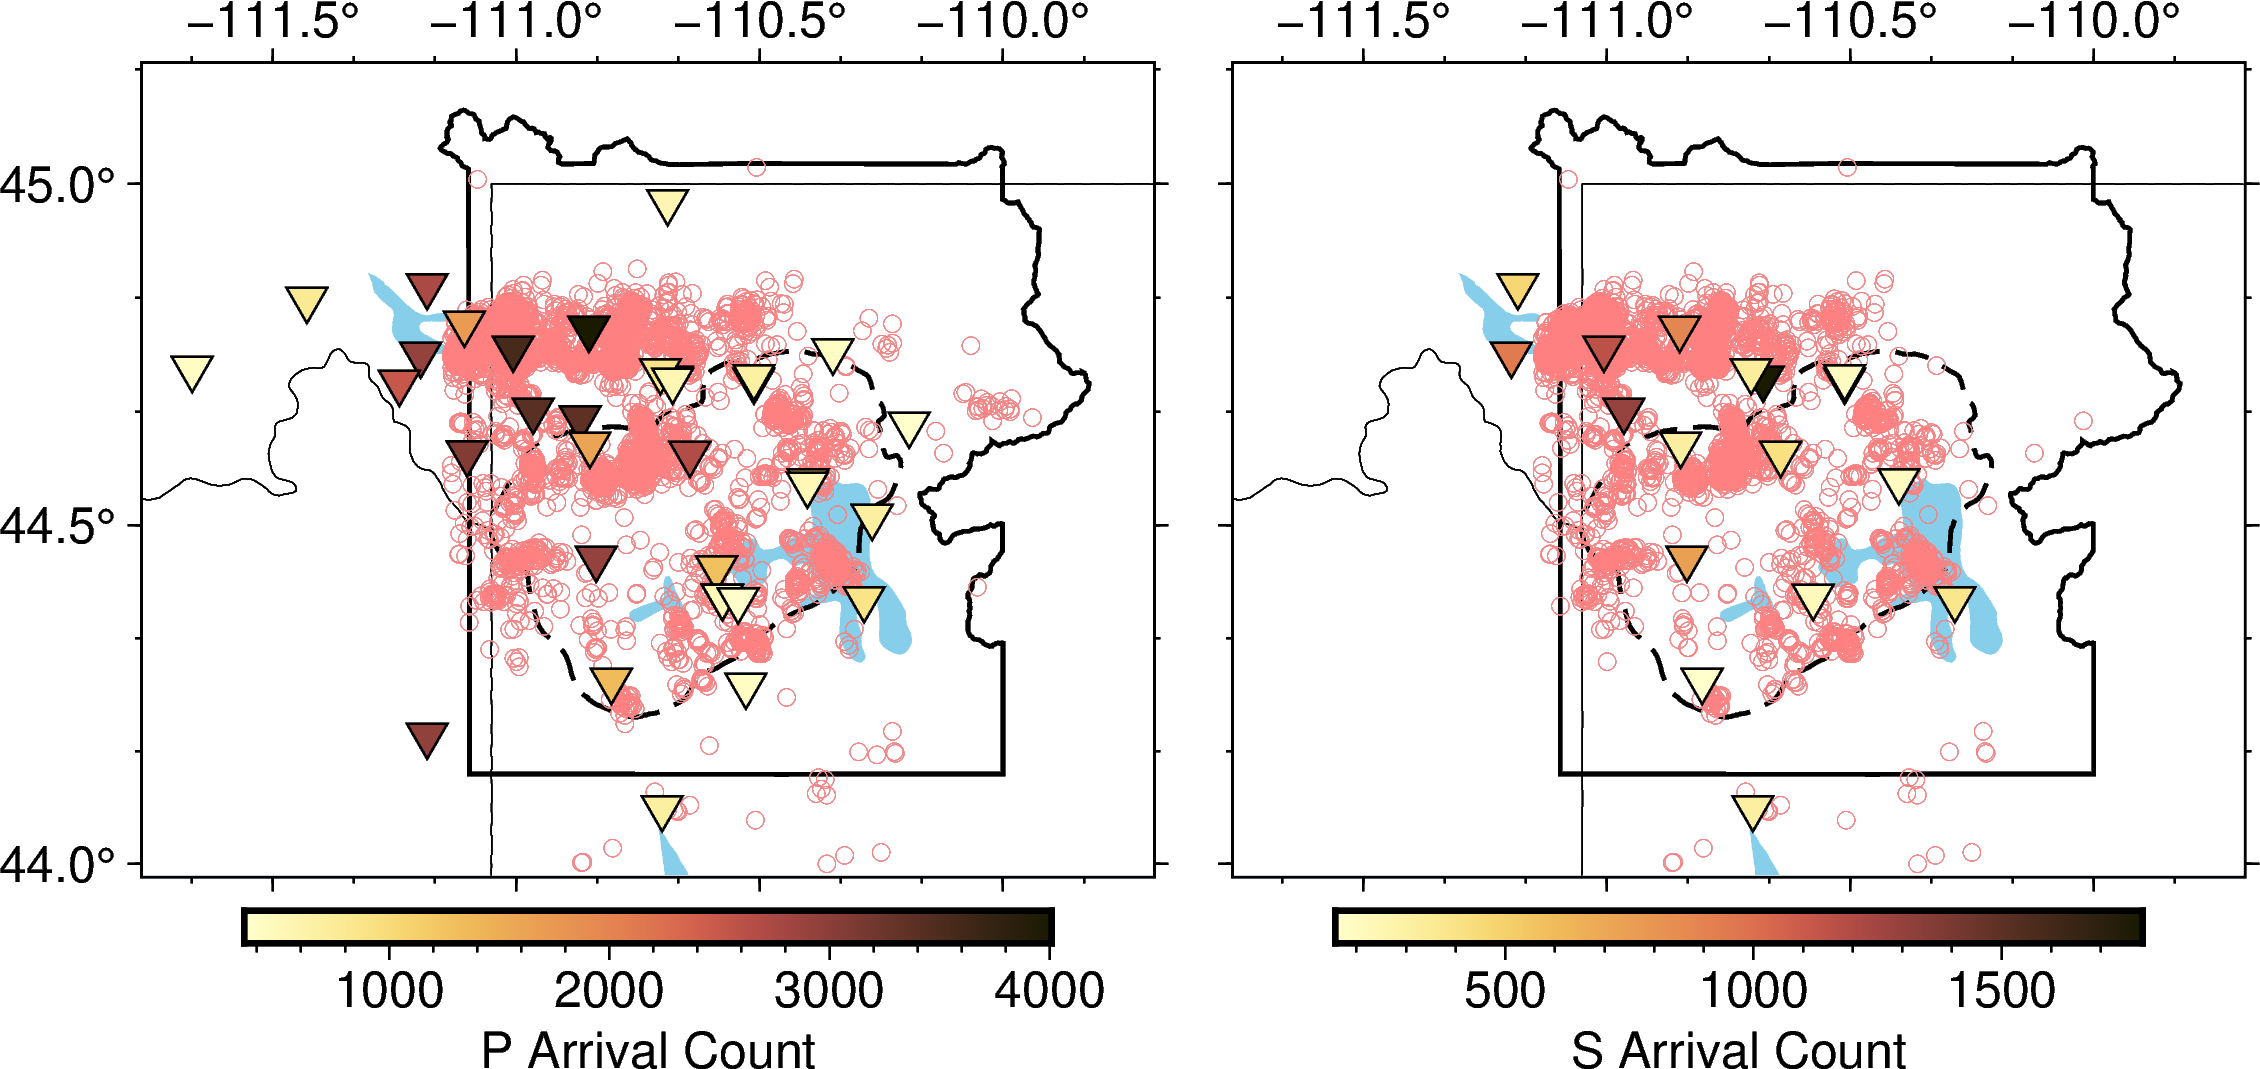

In [37]:
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_TYPE="plain", FONT='12p', FONT_ANNOT_PRIMARY='12p')

region = [
    p_stats.receiver_lon.min() - 0.1,
    p_stats.receiver_lon.max() + 0.5,
    p_stats.receiver_lat.min() - 0.1,
    p_stats.receiver_lat.max() + 0.2,
]

with fig.subplot(ncols=2, figsize=("7i", "4i"), sharey='l', sharex='t'):
    with fig.set_panel(panel=0):  # sets the current panel
        fig.basemap(region=region, projection="M?")
        fig.coast(land="white", borders=2, water="skyblue")
        pygmt.makecpt(cmap="lajolla", series=[p_stats.cnt_train.min(), p_stats.cnt_train.max()])
        fig.plot(data=ys_border, pen="1.0p,black")
        fig.plot(data=caldera, pen='1.0p,black,--')

        fig.plot(data=p_train_ev[["source_longitude", "source_latitude"]], style="c0.15c", pen="0.1p,darkgray")
        fig.plot(data=p_train_ev[["source_longitude", "source_latitude"]], style="c0.15c", pen="0.1p,lightred")

        fig.plot(x=p_stats.receiver_lon, y=p_stats.receiver_lat,
        style="i0.4c", fill=p_stats.cnt_train, cmap=True, pen="0.5p,black")

        fig.colorbar(frame='af+l"P Arrival Count"')
    with fig.set_panel(panel=1):  # sets the current panel
        fig.basemap(region=region, projection="M?")
        fig.coast(land="white", borders=2, water="skyblue")

        pygmt.makecpt(cmap="lajolla", series=[s_stats.cnt_train.min(), s_stats.cnt_train.max()])
        fig.plot(data=ys_border, pen="1.0p,black")
        fig.plot(data=caldera, pen='1.0p,black,--')

        fig.plot(data=s_train_ev[["source_longitude", "source_latitude"]], style="c0.15c", pen="0.1p,darkgray")
        fig.plot(data=s_train_ev[["source_longitude", "source_latitude"]], style="c0.15c", pen="0.1p,lightred")

        fig.plot(x=s_stats.receiver_lon, y=s_stats.receiver_lat,
                 style="i0.4c", fill=s_stats.cnt_train, cmap=True, pen="0.5p,black")

        fig.colorbar(frame='af+l"S Arrival Count"') # @%Times-Italic%
fig.show()
# fig.savefig('side_by_side_station_counts.png', dpi=300)